In [4]:
import numpy as np
import pandas as pd
import os
import cv2
import datetime
import random
from matplotlib import pyplot as plt

from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Flatten, Conv2D, MaxPooling2D, BatchNormalization, Dropout, Conv2DTranspose, Activation
from tensorflow.keras.utils import plot_model
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array

2025-10-11 13:36:24.550238: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1760189784.740858      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1760189784.790461      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [5]:
!nvidia-smi

Sat Oct 11 13:36:36 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.35.03              Driver Version: 560.35.03      CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla P100-PCIE-16GB           Off |   00000000:00:04.0 Off |                    0 |
| N/A   36C    P0             27W /  250W |       0MiB /  16384MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [6]:
import tensorflow as tf
print("GPUs detectadas:", len(tf.config.list_physical_devices('GPU')))
tf.config.list_physical_devices('GPU')

GPUs detectadas: 1


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [7]:
def plot_losses(history):
    plt.rcParams['figure.figsize'] = [20, 5]
    f, (ax1, ax2) = plt.subplots(1, 2, sharex=True)

    ax1.set_title('Losses')
    ax1.set_xlabel('epoch')
    ax1.legend(loc="upper right")
    ax1.grid()
    ax1.plot(history['loss'], label='Training loss')
    ax1.plot(history['val_loss'], label='Validation loss')
    ax1.legend()

    plt.show()

In [8]:
def plot_resultados(model, carpeta, height=64, width=64, n=4):
    """
    Muestra comparaciones entre imágenes originales y reconstruidas por el autoencoder.
    """
    # Seleccionar imágenes aleatorias
    archivos = os.listdir(carpeta)
    archivos_img = random.sample(archivos, n)

    # Cargar y normalizar las imágenes
    imgs_originales = []
    for nombre in archivos_img:
        img = load_img(os.path.join(carpeta, nombre), target_size=(height, width))
        img_array = img_to_array(img) / 255.0  # normalizar a [0,1]
        imgs_originales.append(img_array)

    imgs_originales = np.array(imgs_originales)

    # Reconstruir con el modelo
    imgs_reconstruidas = model.predict(imgs_originales)

    # Mostrar resultados
    plt.figure(figsize=(12, 6))
    for i in range(n):
        # Imagen original
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(imgs_originales[i])
        ax.set_title("Original")
        ax.axis("off")

        # Imagen reconstruida
        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(imgs_reconstruidas[i])
        ax.set_title("Reconstruida")
        ax.axis("off")

    plt.tight_layout()
    plt.show()

## Image analysis

We plot some of the images

In [9]:
# image_dir = '/kaggle/input/animefacedataset/images'

# # Load image file paths
# image_files = [os.path.join(image_dir, f) for f in os.listdir(image_dir)]

# # Read images and collect their shapes
# images = []
# shapes = []
# for file in image_files:
#     img = cv2.imread(file)
#     if img is not None:
#         images.append(img)
#         shapes.append(img.shape)

# # Check if all shapes are the same
# all_same_shape = all(shape == shapes[0] for shape in shapes)
# print("All images same shape:", all_same_shape)
# print("Image shape (height, width, channels):", shapes[0])

# # Plot the first 4 images
# fig, axs = plt.subplots(1, 4, figsize=(16, 4))
# for i in range(min(4, len(images))):
#     img_rgb = cv2.cvtColor(images[i], cv2.COLOR_BGR2RGB)
#     axs[i].imshow(img_rgb)
#     axs[i].axis('off')
#     axs[i].set_title(f'Image {i+1}')
# plt.tight_layout()
# plt.show()


In [10]:
# pd.Series(shapes).value_counts()

Shapes.value_counts()
```
(92, 92, 3)      1636
(96, 96, 3)      1556
(94, 94, 3)      1534
(95, 95, 3)      1530
(90, 90, 3)      1516
                 ... 
(87, 88, 3)         1
(220, 220, 3)       1
(126, 127, 3)       1
(101, 102, 3)       1
(181, 181, 3)       1
Name: count, Length: 181, dtype: int64
```

# Autoencoder

## Defining Hiperparameters

In [11]:
height, width = 64, 64 # Image size, to fit in the competition size
image_dir = '/kaggle/input/animefacedataset'

In [12]:
input_img = keras.Input(shape=(height, width, 3))

# Encoder
x_enc = Conv2D(16, (3, 3), strides=2, padding="same")(input_img)
x_enc = BatchNormalization()(x_enc)
x_enc = Activation("relu")(x_enc)
x_enc = Conv2D(32, (3, 3), strides=2, padding="same")(x_enc)
x_enc = BatchNormalization()(x_enc)
x_enc = Activation("relu")(x_enc)
x_enc = Conv2D(64, (3, 3), strides=2, padding="same")(x_enc)
x_enc = BatchNormalization()(x_enc)
x_enc = Activation("relu")(x_enc)
x_enc = Conv2D(128, (3, 3), strides=2, padding="same")(x_enc)
x_enc = BatchNormalization()(x_enc)
x_enc = Activation("relu")(x_enc)
x_enc = Conv2D(256, (3, 3), strides=2, padding="same")(x_enc)
x_enc = BatchNormalization()(x_enc)
encoded = Activation("relu")(x_enc)

# Decoder
x_dec = Conv2DTranspose(256, (3, 3), strides=2, padding="same")(encoded)
x_dec = BatchNormalization()(x_dec)
x_dec = Activation("relu")(x_dec)
x_dec = Conv2DTranspose(128, (3, 3), strides=2, padding="same")(x_dec)
x_dec = BatchNormalization()(x_dec)
x_dec = Activation("relu")(x_dec)
x_dec = Conv2DTranspose(64, (3, 3), strides=2, padding="same")(x_dec)
x_dec = BatchNormalization()(x_dec)
x_dec = Activation("relu")(x_dec)
x_dec = Conv2DTranspose(32, (3, 3), strides=2, padding="same")(x_dec)
x_dec = BatchNormalization()(x_dec)
x_dec = Activation("relu")(x_dec)
x_dec = Conv2DTranspose(16, (3, 3), strides=2, padding="same")(x_dec)
x_dec = BatchNormalization()(x_dec)
x_dec = Activation("relu")(x_dec)

decoded = Conv2DTranspose(3, (3, 3), activation="sigmoid", padding="same")(x_dec)



I0000 00:00:1760189797.077284      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


We define the autoencoder, encoder and decoder

In [13]:
autoencoder = keras.Model(input_img, decoded)
encoder = keras.Model(input_img, encoded)
decoder = keras.Model(encoded, decoded)

In [14]:
autoencoder.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 64, 64, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 32, 32, 16)     │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 32, 32, 16)     │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 32, 32, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 16, 16, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 16, 16, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 8, 8, 64)       │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 8, 8, 64)       │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 4, 4, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 4, 4, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 2, 2, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 2, 2, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 2, 2, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 4, 4, 256)      │       590,080 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 4, 4, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_5 (Activation)       │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 8, 8, 128)      │       295,040 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 8, 8, 128)      │           51

 Total params: 1,379,011 (5.26 MB)

 Trainable params: 1,377,027 (5.25 MB)

 Non-trainable params: 1,984 (7.75 KB)

## ImageDataGenerator

To fit with the competition, we will reshape images to 64x64

In [15]:
datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

# Create training and validation generators using the same seed
train_generator = datagen.flow_from_directory(
    image_dir,
    target_size=(height, width),  
    batch_size=256,
    class_mode='input',
    subset='training',
    shuffle=True,
    seed=2004  
)

val_generator = datagen.flow_from_directory(
    image_dir,
    target_size=(height, width),
    batch_size=256,
    class_mode='input',
    subset='validation',
    shuffle=False,
    seed=2004
)

Found 50852 images belonging to 1 classes.
Found 12713 images belonging to 1 classes.


## Train

In [16]:
opt = keras.optimizers.Adam(learning_rate=1e-3)
autoencoder.compile(optimizer=opt, loss="mse")

In [17]:
# Fit the autoencoder
h = autoencoder.fit(
    train_generator,
    epochs=30,
    validation_data=val_generator
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30


I0000 00:00:1760189904.656610      98 service.cc:148] XLA service 0x7e7d7412bd50 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1760189904.657356      98 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1760189905.635914      98 cuda_dnn.cc:529] Loaded cuDNN version 90300


  1/199 ━━━━━━━━━━━━━━━━━━━━ 59:44 18s/step - loss: 0.1351

I0000 00:00:1760189912.725247      98 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


199/199 ━━━━━━━━━━━━━━━━━━━━ 296s 1s/step - loss: 0.0539 - val_loss: 0.0424
Epoch 2/30
199/199 ━━━━━━━━━━━━━━━━━━━━ 65s 325ms/step - loss: 0.0221 - val_loss: 0.0250
Epoch 3/30
199/199 ━━━━━━━━━━━━━━━━━━━━ 64s 319ms/step - loss: 0.0193 - val_loss: 0.0223
Epoch 4/30
199/199 ━━━━━━━━━━━━━━━━━━━━ 64s 322ms/step - loss: 0.0180 - val_loss: 0.0197
Epoch 5/30
199/199 ━━━━━━━━━━━━━━━━━━━━ 61s 306ms/step - loss: 0.0169 - val_loss: 0.0196
Epoch 6/30
199/199 ━━━━━━━━━━━━━━━━━━━━ 64s 319ms/step - loss: 0.0157 - val_loss: 0.0171
Epoch 7/30
199/199 ━━━━━━━━━━━━━━━━━━━━ 62s 309ms/step - loss: 0.0149 - val_loss: 0.0172
Epoch 8/30
199/199 ━━━━━━━━━━━━━━━━━━━━ 63s 319ms/step - loss: 0.0144 - val_loss: 0.0159
Epoch 9/30
199/199 ━━━━━━━━━━━━━━━━━━━━ 65s 326ms/step - loss: 0.0139 - val_loss: 0.0150
Epoch 10/30
199/199 ━━━━━━━━━━━━━━━━━━━━ 63s 314ms/step - loss: 0.0135 - val_loss: 0.0149
Epoch 11/30
199/199 ━━━━━━━━━━━━━━━━━━━━ 65s 328ms/step - loss: 0.0132 - val_loss: 0.0148
Epoch 12/30
199/199 ━━━━━━━━━━━━

In [21]:
# hacemos fine tunning para logar un mejor modelo
opt2 = keras.optimizers.Adam(learning_rate=5e-4)
autoencoder.compile(optimizer=opt2, loss="mae")

h = autoencoder.fit(
    train_generator,
    epochs=10,
    validation_data=val_generator
)

Epoch 1/10
199/199 ━━━━━━━━━━━━━━━━━━━━ 86s 362ms/step - loss: 0.0671 - val_loss: 0.0691
Epoch 2/10
199/199 ━━━━━━━━━━━━━━━━━━━━ 65s 326ms/step - loss: 0.0657 - val_loss: 0.0687
Epoch 3/10
199/199 ━━━━━━━━━━━━━━━━━━━━ 64s 320ms/step - loss: 0.0655 - val_loss: 0.0681
Epoch 4/10
199/199 ━━━━━━━━━━━━━━━━━━━━ 64s 322ms/step - loss: 0.0651 - val_loss: 0.0689
Epoch 5/10
199/199 ━━━━━━━━━━━━━━━━━━━━ 67s 336ms/step - loss: 0.0650 - val_loss: 0.0679
Epoch 6/10
199/199 ━━━━━━━━━━━━━━━━━━━━ 67s 335ms/step - loss: 0.0651 - val_loss: 0.0678
Epoch 7/10
199/199 ━━━━━━━━━━━━━━━━━━━━ 67s 338ms/step - loss: 0.0646 - val_loss: 0.0684
Epoch 8/10
199/199 ━━━━━━━━━━━━━━━━━━━━ 65s 329ms/step - loss: 0.0645 - val_loss: 0.0677
Epoch 9/10
199/199 ━━━━━━━━━━━━━━━━━━━━ 65s 326ms/step - loss: 0.0644 - val_loss: 0.0671
Epoch 10/10
199/199 ━━━━━━━━━━━━━━━━━━━━ 66s 329ms/step - loss: 0.0644 - val_loss: 0.0675


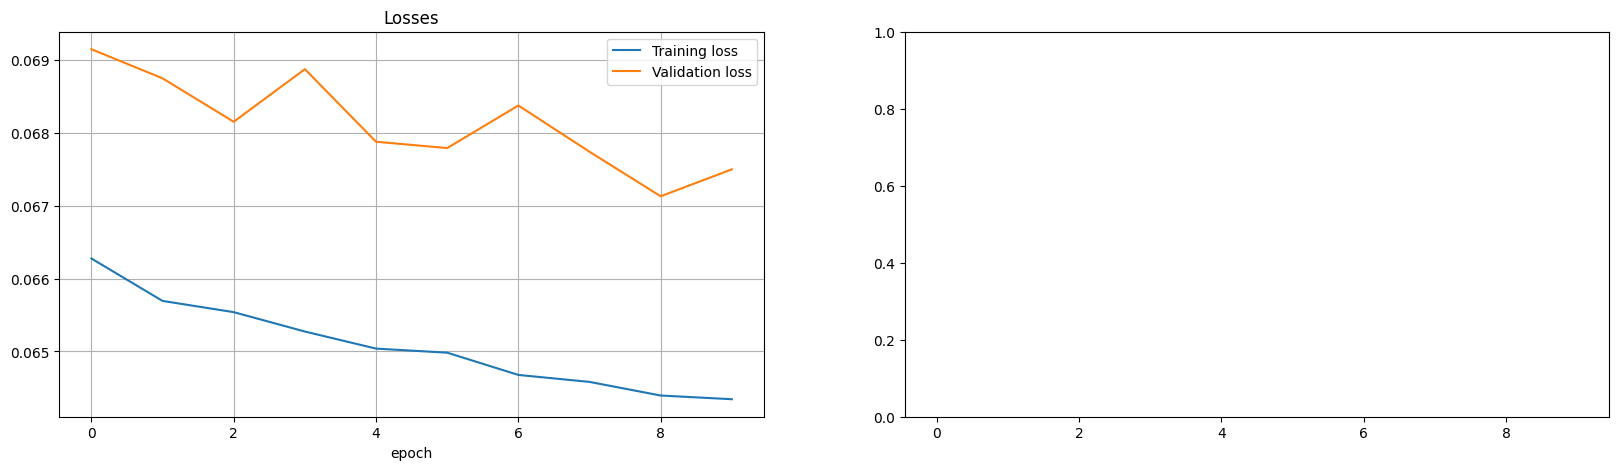

In [23]:
plot_losses(h.history)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 853ms/step


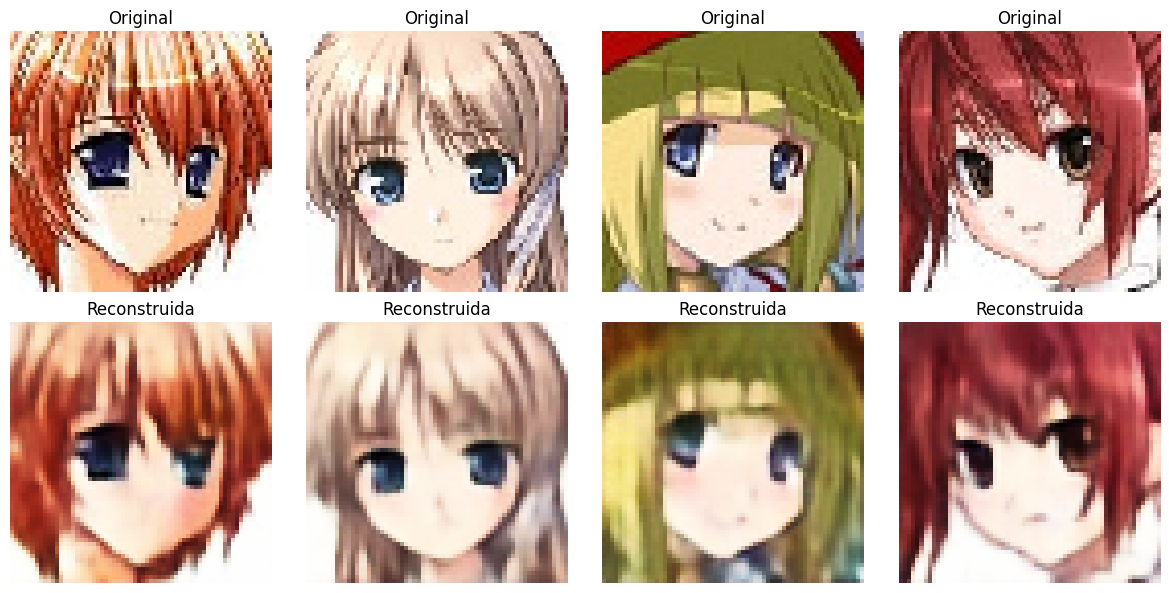

In [24]:
image_dir="/kaggle/input/animefacedataset/images"
plot_resultados(autoencoder,image_dir)

In [25]:
# Current timestamp
timestamp = datetime.datetime.now().strftime("%m_%d_%H:%M")
## Make sure everything saves correctly
os.makedirs("models", exist_ok=True)

model_path = f"models/autoencoder_v2_{timestamp}.keras"

# Save the model
autoencoder.save(model_path)
